In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from nltk.tokenize import wordpunct_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer

#### Load in data

In [2]:
data = pd.read_csv('allerhande_preprocessed.csv', index_col=0)
print(data.head())

        id                                   title  \
0   861106            ['vegetarisch', 'bonenstof']   
1   680104                   ['fris', 'limoenrom']   
2   683858  ['kalkoenfilet', 'champignonroomsaus']   
3  1187074     ['andijvie', 'rauw', 'ham', 'prei']   
4   660152        ['spruit', '-', 'rozijnensalad']   

                                         description        course  \
0  ['stoofgerecht', 'vegetarisch', 'balletjes', '...  hoofdgerecht   
1  ['recept', '.', 'nagerecht', 'bevat', 'volgend...     nagerecht   
2  ['kidsprof', 'winter', 'recept', 'pasta', 'kal...  hoofdgerecht   
3  ['bijgerecht', 'andijvie', ',', 'prei', ',', '...    bijgerecht   
4  ['holland', 'recept', '.', 'vegetarisch', 'bij...    bijgerecht   

   recipe_yield                                        ingredients  calories  \
0           4.0  ['olijfolie', 'tomatenblokjes', 'bruine bon', ...     410.0   
1           4.0  ['limoen', 'slagrom', 'vloeibare hon', 'grieks...     290.0   
2           4.

In [3]:
view_data = pd.read_csv('allerhande_raw.csv', index_col=0)
print(view_data.head())
view_data.drop_duplicates(subset='id', inplace=True)

        id                                title  \
0   861106              Vegetarische bonenstoof   
1   680104                    Frisse limoenroom   
2   683858  Kalkoenfilet met champignonroomsaus   
3  1187074       Andijvie met rauwe ham en prei   
4   660152              Spruiten-rozijnensalade   

                                         description        course  \
0  Stoofgerecht met vegetarische balletjes, aarda...  hoofdgerecht   
1  Een lekker recept. Het nagerecht bevat de volg...     nagerecht   
2  Kidsproof winters recept voor pasta met kalkoe...  hoofdgerecht   
3  bijgerecht met andijvie, prei, knoflook, tijm ...    bijgerecht   
4  Een lekker hollands recept. Het vegetarische b...    bijgerecht   

  recipe_yield                                        ingredients calories  \
0   4 personen  {'olijfolie': '2 el()', 'tomatenblokjes': '800...  410kcal   
1   4 personen  {'limoenen': ' 2(schoongeboend)', 'slagroom': ...  290kcal   
2   4 personen  {'olijfolie': '2 el()'

In [13]:
print(data.columns)

Index(['id', 'title', 'description', 'course', 'recipe_yield', 'ingredients',
       'calories', 'protein', 'carbohydrates', 'fat', 'saturated_fat',
       'sodium', 'fiber', 'cooking_time', 'rating', 'review_count',
       'recipe_instruction', 'tags', 'appliances', 'type'],
      dtype='object')


In [25]:
print(max(data['calories']))
print(max(data['protein']))
print(max(data['carbohydrates']))
print(max(data['fat']))
print(max(data['saturated_fat']))
print(max(data['sodium']))
print(max(data['fiber']))
print(max(data['cooking_time']))

7680.0
839.0
559.0
520.0
755.0
7655.0
400.0
1450.0


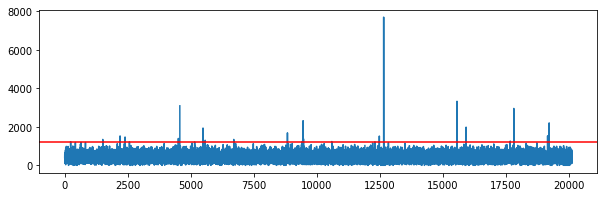

In [76]:
plt.figure(figsize=(10,3))
plt.plot(data['calories'])
plt.axhline(y=1200, color='r', linestyle='-')
plt.show()

In [80]:
a = set([1, 2, 3, 4, 5])
b = set([1, 2, 3, 4, 5])
a.intersection(b)

{1, 2, 3, 4, 5}

#### Load in inverted columns and convert to dict

In [4]:
inverted_ingredients_pd = pd.read_csv('inverted_list_ingredients.csv', header=None, names=['Word', 'Index'])
print(inverted_ingredients_pd.head())
inverted_ingredients_dict = pd.Series(inverted_ingredients_pd.Index.values,index=inverted_ingredients_pd.Word).to_dict()

                                       Word  \
0                                datterrini   
1                  mexicaanse roerbakgroent   
2                  zachte boter of margarin   
3  stoomgroenten (broccoli/rode ui/paprika)   
4                             bruine suiker   

                                               Index  
0                                             [6320]  
1  [537, 847, 1473, 1544, 2056, 2511, 6391, 6492,...  
2            [3262, 6202, 6579, 13639, 15010, 16674]  
3                                            [10181]  
4  [1442, 2110, 7265, 8615, 9369, 10257, 11532, 1...  


In [5]:
inverted_tags_pd = pd.read_csv('inverted_list_tags.csv', header=None, names=['Word', 'Index'])
# remove row with value NaN
index_nr = []
for i, word in enumerate(inverted_tags_pd['Word']):
    if type(word) is not str:
        index_nr.append(i)
inverted_tags_pd.drop(index_nr, inplace=True)
print(inverted_tags_pd.head())
inverted_tags_dict = pd.Series(inverted_tags_pd.Index.values,index=inverted_tags_pd.Word).to_dict()

                Word                                              Index
1              slank  [0, 45, 67, 135, 172, 221, 260, 344, 369, 386,...
2        advertorial                                       [5741, 7705]
3   sinterklaasavond  [572, 585, 960, 1132, 1583, 1890, 2594, 3162, ...
4        mediterraan  [8, 108, 211, 334, 344, 462, 470, 474, 514, 57...
5              turks  [660, 812, 1294, 1425, 1622, 2150, 2170, 2983,...


In [6]:
inverted_types_pd = pd.read_csv('inverted_list_types.csv', header=None, names=['Word', 'Index'])
print(inverted_types_pd.head())
inverted_types_dict = pd.Series(inverted_types_pd.Index.values,index=inverted_types_pd.Word).to_dict()

        Word                                              Index
0       koek  [102, 134, 228, 648, 690, 749, 888, 976, 1005,...
1  carpaccio  [11, 19, 23, 34, 778, 1285, 1533, 1644, 1796, ...
2         ei  [41, 51, 218, 270, 294, 443, 485, 522, 533, 65...
3  chocolade  [371, 2462, 3250, 4764, 5339, 5858, 7796, 9814...
4   cocktail  [427, 828, 926, 1251, 1558, 1650, 1818, 2000, ...


In [7]:
inverted_title_pd = pd.read_csv('inverted_list_title.csv', header=None, names=['Word', 'Index'])
print(inverted_title_pd.head())
index_nr = []
for i, word in enumerate(inverted_title_pd['Word']):
    if type(word) is not str:
        index_nr.append(i)
print(index_nr)
print(len(inverted_title_pd['Word']))
# print(index_nr)
inverted_title_pd.drop(index_nr, inplace=True)
inverted_title_dict = pd.Series(inverted_title_pd.Index.values,index=inverted_title_pd.Word).to_dict()


            Word   Index
0     peulvrucht  [2591]
1   puntasperges  [3194]
2    advertorial  [7918]
3       pantosti  [6045]
4  kaascroissant  [2751]
[2668]
8694


#### First for only one word in only one inverted column

In [8]:
# word = str, inverted_column = dict, retrieved_docs = list
def retrieve_inverted_column(word, inverted_column):
    retrieved_docs = []
    for key in inverted_column.keys():
        if word in key:
            retrieved_docs += ast.literal_eval(inverted_column.get(key))
    return list(set(retrieved_docs))

## Retrieval system
- tokenize query, remove all tokens that have len = 1, since these are not words
- for each word in query, create set of documents containing this word
    - look through each inverted column to retrieve possible documents
- get the intersection of the document sets of each word to only retrieve documents with all query words
- print all retrieved documents

In [9]:
# query = str, inverted_column = list of dicts?
def retrieve(query, inverted_columns, dataset):
    tokens = word_tokenize(query)
    words = [item for item in tokens if len(item) > 1]
    
    # lowercase & stemmen
    words = [y.lower() for y in words]
    stemmer = SnowballStemmer("dutch")
    words = [stemmer.stem(y) for y in words]
    
    set_per_word = []
    
    # loop through query words
    for word in words:
        
        # get set of retrieved docs for each word
        retrieved_docs_word = []
        for column in inverted_columns:
            retrieved_docs_word += retrieve_inverted_column(word, column)
        set_per_word.append(set(retrieved_docs_word))
    
    # get intersection of sets for whole query
    retrieved = set_per_word[0]
    for element in set_per_word[1:]:
        retrieved = retrieved.intersection(element)
        
    # print all retrieved recipes
    for index in retrieved:
        print(dataset.iloc[index,:])
        print('\n')
        
    return list(retrieved)   
    

In [10]:
test1 = retrieve("ijskoffie", [inverted_ingredients_dict, inverted_tags_dict, inverted_types_dict, inverted_title_dict],data)
print(test1)
print(data.iloc[test1[0],1])
print(view_data.iloc[test1[0],1])

id                                                               549844
title                                        ['ijskoffie', 'chocorasp']
description           ['recept', '.', 'vegetarisch', 'nagerecht', 'b...
course                                                        nagerecht
recipe_yield                                                          4
ingredients                   ['sterke koffie', 'pure chocolad', 'ijs']
calories                                                            105
protein                                                               2
carbohydrates                                                        12
fat                                                                   6
saturated_fat                                                       NaN
sodium                                                              NaN
fiber                                                               NaN
cooking_time                                                    

## User interface test

In [11]:
from tkinter import *
from PIL import Image, ImageTk

In [12]:
# Function to retrieve recipes
def click():
    entered_text = textentry.get()
    results.delete(0, END)
    information.delete(0.0, END)
    global recipes
    recipes = retrieve(entered_text, [inverted_ingredients_dict, inverted_tags_dict, inverted_types_dict, inverted_title_dict],data)
    for i, element in enumerate(recipes):
        results.insert(END, view_data.iloc[element,1])

# Function to show additional information for the selected recipe
def show_descr():
    selected_recipe = results.curselection()
    recipe_index = recipes[int(selected_recipe[0])]
    information.delete(0.0, END)
    information.insert(END, "Omschrijving \n", 'big')
    information.insert(END, view_data.iloc[recipe_index,2] + '\n', 'normal')
    information.insert(END, '\nIngrediënten \n', 'big')
    for ingredient in ast.literal_eval(view_data.iloc[recipe_index,5]):
        information.insert(END, ingredient + '\n', 'normal')
    

# General window settings
window = Tk()
window.title('Recepten zoeker v.1')
window.configure(background='white')
window.geometry("{}x{}".format(window.winfo_screenwidth(), window.winfo_screenheight()))

image = Image.open("bestek.png")
photo1 = ImageTk.PhotoImage(Image.open("bestek.png"))
Label(window, image=photo1).grid(row=0,column = 0, columnspan = 4, sticky=W+E+N+S)

Label(window, text="Wat wil je eten vanavond?", font='none 24 bold').grid(row=1,column=0,columnspan = 4,sticky=E+W)

# Query box
textentry = Entry(window, width = 75)
textentry.grid(row=3,column=0,columnspan = 4,sticky=W)

Button(window, text='Zoek recepten', width=13, command=click, font='none 18 bold').grid(row=3,column=2,sticky=W)

Label(window, text='Gevonden recepten',font='none 18 bold').grid(row=4,column=0,sticky=E+W)

# Box that shows all retrieved recipes
results = Listbox(window, height = 15, width = 75)
results.grid(row=5,column=0,columnspan=2,sticky=E+W)

# Box that shows additional information about recipe
information = Text(window, width=75, height=15, wrap=WORD)
information.tag_configure('big', font=('none', 14, 'bold'))
information.tag_configure('normal', font=('none', 14))
information.grid(row=5, column=2, columnspan=2, sticky=E+W)

Button(window, text="Klik hier om meer informatie te krijgen over het geselecteerde recept", command=show_descr, font='none 16 bold').grid(row=6, column=0, columnspan=2, sticky=W)

window.mainloop()